# Quickstart Example with Synthetic RTB Simulation and Dataset (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) with synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps: \
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import offlinegym modules
import offlinegym
from rtbgym import RTBEnv, CustomizedRTBEnv
from offlinegym.dataset import SyntheticDataset
from offlinegym.policy import OnlineHead
from offlinegym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(offlinegym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we adjust bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration , please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

Let's see how it works!

In [9]:
# setup environment
env = RTBEnv(random_state=random_state)

In [10]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [11]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [12]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


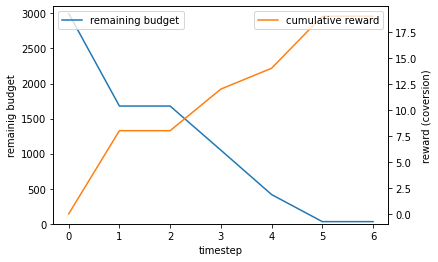

In [13]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy soon run out the budget.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward within the given budget constraints.

For more about the environmental configurations and customization, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to random policy, using on-policy policy estimation.

In [14]:
# standardized environemnt for discrete action
env = gym.make("RTBEnv-discrete-v0")
print(env.action_meaning)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [15]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [16]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2022-06-09 13:06.01 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20220609130601
2022-06-09 13:06.01 [debug    ] Building model...
2022-06-09 13:06.01 [debug    ] Model has been built.
2022-06-09 13:06.01 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20220609130601/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (7,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-06-09 13:06.02 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220609130601/model_1000.pt
2022-06-09 13:06.02 [info     ] DoubleDQN_online_20220609130601: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00034343695640563966, 'time_environment_step': 0.0005806100368499756, 'time_step': 0.0009608530998229981, 'rollout_return': 12.950704225352112, 'evaluation': 14.2} step=1000
2022-06-09 13:06.05 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220609130601/model_2000.pt
2022-06-09 13:06.05 [info     ] DoubleDQN_online_20220609130601: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00030292439460754395, 'time_environment_step': 0.0006048946380615235, 'time_sample_batch': 7.404613494873047e-05, 'time_algorithm_update': 0.0012749712467193604, 'loss': 63.913463223457335, 'time_step': 0.002316171646118164, 'rollout_return': 13.091549295774648, 'evaluation': 0.0} step=2000
2022-06-09 13:06.07 [info     ] Model parameters are s

In [18]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [16]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

Text(0, 0.5, 'episode reward')

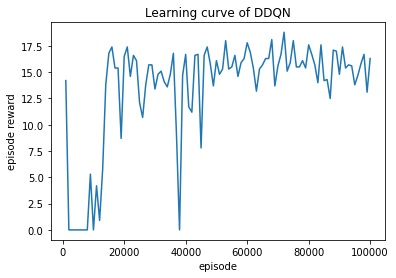

In [17]:
# we see that training RL policy can be risky online
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [19]:
random = DiscreteRandomPolicy()
random.build_with_env(env)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

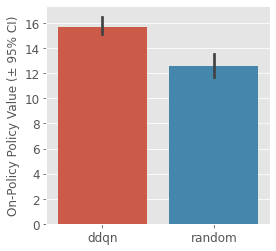

In [20]:
# compare performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [21]:
# on-policy policy value by ddqn policy
# largely outperforms random policy (about 20%)
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_episodes=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_episodes=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.1928625664388763


## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact the environment *online* using synthetic simulator.  
Though simulation is a good start for training agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in real-world implementataion.  
Therefore, we introduce alternative learning protocol, Offline RL, which aim to obtain a new policy using only offline logged dataset.

We prepare easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

In [22]:
# import necessary module from offlinegym
from offlinegym.policy import DiscreteEpsilonGreedyHead

In [23]:
behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [24]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    is_rtb_env=True,
    random_state=random_state,
)

In [25]:
# collect logged data using behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 1.33732502e-01],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 5.99484250e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 3.20000000e+01, 9.42549372e-01, ...,
         5.55555556e-01, 2.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [27]:
with open("logs/dataset_discrete.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [28]:
with open("logs/dataset_discrete.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

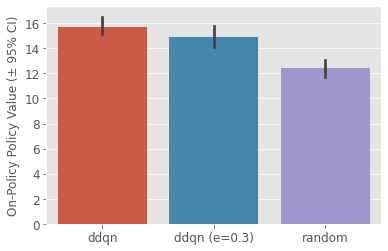

In [29]:
# compare performance online
# almost same performance with greedy ddqn
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [30]:
# check statistics of the dataset
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.143551,118.761797,91.315629,9.089029,2.168043,0.515376,0.071215,0.144263
std,2.299263,122.256154,81.529734,8.865248,2.888160,0.385988,0.076777,0.179844
min,0.000042,4.051887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.774264,59.905646,4.000000,0.000000,0.000000,0.049327,0.000000,0.000000
50%,1.291550,64.509804,90.000000,9.000000,1.000000,0.677419,0.080000,0.083333
75%,2.154435,165.974645,167.000000,17.000000,3.000000,0.828960,0.109756,0.250000
max,10.000000,546.900000,290.000000,41.000000,20.000000,1.000000,0.999997,0.999998


For more about the data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting to the environment.  
To achieve this goal, we exploit logged dataset and train the policy on the data.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [31]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.ope import DiscreteFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [32]:
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [33]:
# Use Conservetive Q-Learning policy
cql = DiscreteCQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [34]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

2022-06-09 13:11.45 [debug    ] RandomIterator is selected.
2022-06-09 13:11.45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20220609131145
2022-06-09 13:11.45 [debug    ] Building models...
2022-06-09 13:11.45 [debug    ] Models have been built.
2022-06-09 13:11.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20220609131145/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-06-09 13:12.05 [info     ] DiscreteCQL_20220609131145: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0001240518808364868, 'time_algorithm_update': 0.0017827794551849366, 'loss': 66.8778075091362, 'time_step': 0.0020425372123718264, 'environment': 16.1} step=10000
2022-06-09 13:12.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20220609131145/model_10000.pt


[(1,
  {'time_sample_batch': 0.0001240518808364868,
   'time_algorithm_update': 0.0017827794551849366,
   'loss': 66.8778075091362,
   'time_step': 0.0020425372123718264,
   'environment': 16.1})]

In [35]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [36]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2022-06-09 13:12.09 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

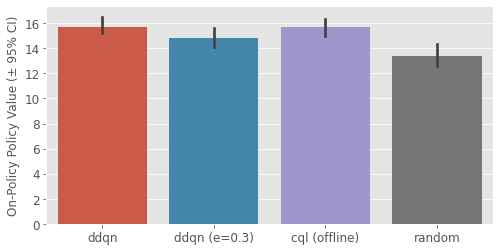

In [37]:
# compare performance online
# not better than online policy, but achieves almost the same performance
# meaning that we can learn a reasonable policy without interacting with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_episodes=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim to evaluate the performance of policies in an offline manner, to gain prior knowledge on how agent works in the environment.

In [38]:
# import ope modules from offlinegym
from offlinegym.ope import CreateOPEInput
from offlinegym.ope import DiscreteOffPolicyEvaluation as OPE
from offlinegym.ope import DiscreteDirectMethod as DM
from offlinegym.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from offlinegym.ope import DiscretePerDecisionImportanceSampling as PDIS
from offlinegym.ope import DiscreteDoublyRobust as DR
from offlinegym.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from offlinegym.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from offlinegym.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [39]:
# define evaluation policies
cql_ = DiscreteEpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = DiscreteEpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = DiscreteEpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [40]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    logged_dataset=logged_dataset,
    use_base_model=True,  # use model-based prediction
)

In [41]:
# takes time
input_dict = prep.obtain_whole_inputs(
    evaluation_policies=evaluation_policies,
    env=env,
    n_episodes_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2022-06-09 13:12.22 [debug    ] RandomIterator is selected.
2022-06-09 13:12.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220609131222
2022-06-09 13:12.22 [debug    ] Building models...
2022-06-09 13:12.22 [debug    ] Models have been built.
2022-06-09 13:12.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131222/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-06-09 13:12.42 [info     ] DiscreteFQE_20220609131222: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003205966949462891, 'time_algorithm_update': 0.0014626028299331666, 'loss': 4.042461380803585, 'time_step': 0.0019375526428222656} step=10000
2022-06-09 13:12.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131222/model_10000.pt
2022-06-09 13:12.42 [debug    ] RandomIterator is selected.
2022-06-09 13:12.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220609131242
2022-06-09 13:12.42 [debug    ] Building models...
2022-06-09 13:12.42 [debug    ] Models have been built.
2022-06-09 13:12.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131242/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-06-09 13:13.02 [info     ] DiscreteFQE_20220609131242: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003221126079559326, 'time_algorithm_update': 0.0014751283407211304, 'loss': 1.5549487250626086, 'time_step': 0.0019417073249816895} step=10000
2022-06-09 13:13.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131242/model_10000.pt
2022-06-09 13:13.02 [debug    ] RandomIterator is selected.
2022-06-09 13:13.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20220609131302
2022-06-09 13:13.02 [debug    ] Building models...
2022-06-09 13:13.02 [debug    ] Models have been built.
2022-06-09 13:13.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131302/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2022-06-09 13:13.20 [info     ] DiscreteFQE_20220609131302: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003401743173599243, 'time_algorithm_update': 0.0012704248428344726, 'loss': 3.693067208188772, 'time_step': 0.0017589282751083375} step=10000
2022-06-09 13:13.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20220609131302/model_10000.pt


[collect input data]:   0%|          | 0/3 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [43]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [44]:
ope = OPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [45]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [46]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     15.680000               1.000000
 dm            12.001753               0.765418
 tis            1.101315               0.070237
 pdis          11.526453               0.735105
 dr            15.624346               0.996451
 sntis         16.666667               1.062925
 snpdis        13.643907               0.870147
 sndr          16.658216               1.062386,
 'ddqn':            policy_value  relative_policy_value
 on_policy     15.730000               1.000000
 dm            14.897795               0.947094
 tis           16.074373               1.021893
 pdis          15.896977               1.010615
 dr            15.838769               1.006915
 sntis         15.926457               1.012489
 snpdis        15.804679               1.004748
 sndr          15.833890               1.006605,
 'random':            policy_value  relative_policy_value
 on_policy     12.570000               1.000000
 dm          

In [47]:
# estimated policy performance confidence intervals
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  15.674200         14.924750         16.426750
 dm         12.001751         12.001506         12.002030
 tis         1.163209          0.000000          2.538531
 pdis       11.669742          8.834191         15.848273
 dr         15.643102         14.118618         17.548221
 sntis      17.603333          0.000000         38.416667
 snpdis     13.936695          9.826332         18.080812
 sndr       16.612210         14.874601         18.806371,
 'ddqn':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  15.685600         14.930000         16.346750
 dm         14.897840         14.889316         14.906235
 tis        16.092178         15.109123         16.997803
 pdis       15.910241         15.650408         16.200529
 dr         15.846785         15.755260         15.940210
 sntis      15.944099         14.970090         16.841390
 snpdis     15.817877         15.559473         16.10654

## 4. Evaluation of OPE methods
Now, we evaluate how well ope estimators estimated the policy value.

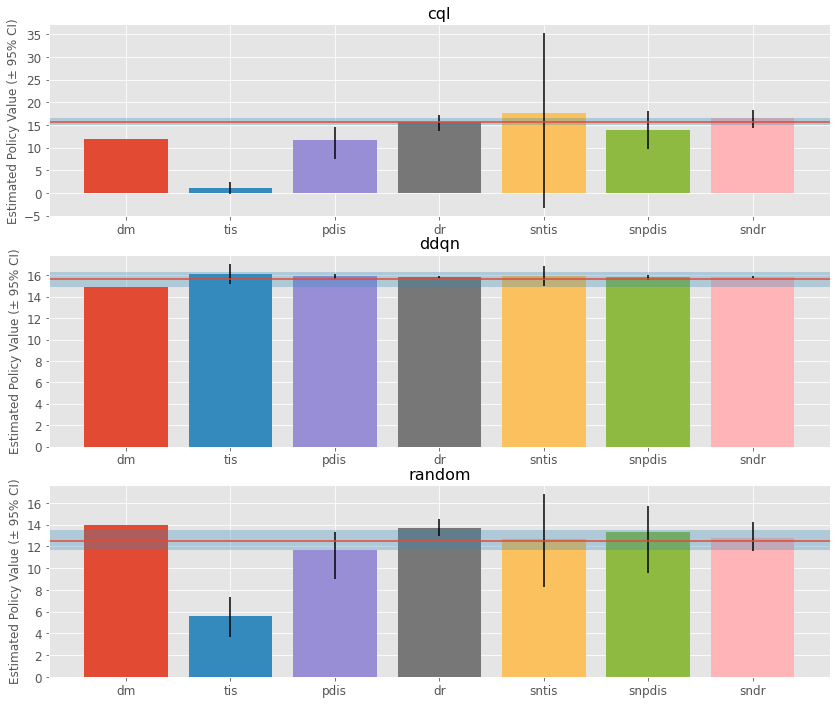

In [48]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while (trajectory-wise) importance sampling estimators have a smaller bias with a larger variance.
# self-normalized estimators also works well
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [49]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.summarize_estimators_comparison(input_dict, metric="se")
eval_metric_ope_df

,cql,ddqn,random
dm,13.529500,0.692564,2.018646
tis,212.538054,0.118592,49.146991
pdis,17.251951,0.027881,0.673836
dr,0.003097,0.011831,1.220868
sntis,0.973511,0.038596,0.009601
snpdis,4.145675,0.005577,0.718898
sndr,0.956906,0.010793,0.049524


For more advanced topics in OPE (e.g., cumulative distribution function estimation and distributionally robust estimation) and OPS, please refer to [examples/quickstart/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_advanced.ipynb). \
For the examples in the continuous action space, please refer to [examples/quickstart/rtb_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_basic.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.